In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-06-04 19:27:54.057760


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-15.5064)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.7583)
penalty_target_min tensor(-12.0983) penalty_target_max tensor(17.6902)
train_loss:  -9.90131923904419
valid_loss:  -8.956351644897461
h_min_tilde -12.098343 ell_tilde -9.712325720214844 kappa_tilde 0.0006473858716097955


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.8235745429992676

 2 6.649633169174194

 3 6.793822288513184

 4 4.129284858703613

 5 3.1489717960357666

 6 3.2543299198150635

 7 3.2336885929107666

 8 3.2676799297332764

 9 3.300450325012207

 10 3.252826452255249

 11 3.2277190685272217

 12 3.215937614440918

 13 3.274033784866333

 14 3.23457670211792

 15 3.3065130710601807

 16 3.24822735786438

 17 3.233328104019165

 18 3.1668148040771484

 19 3.232879638671875

 20 3.241077423095703

 21 3.20810604095459

 22 3.2909255027770996

 23 3.2517809867858887

 24 3.132599353790283

 25 3.2782537937164307

 26 3.2678513526916504

 27 3.1590590476989746

 28 3.0914790630340576

 29 3.1058738231658936

 30 3.1022825241088867

 31 3.177284002304077

 32 3.194687843322754

 33 3.089684009552002

 34 3.2122697830200195

 35 3.2743847370147705

 36 3.1926023960113525

 37 3.182809352874756

 38 3.161682367324829

 39 3.253484010696411

 40 3.2147974967956543

 41 3.256535291671753

 42 3.12785267829895

 43 3.201272964477539

 44

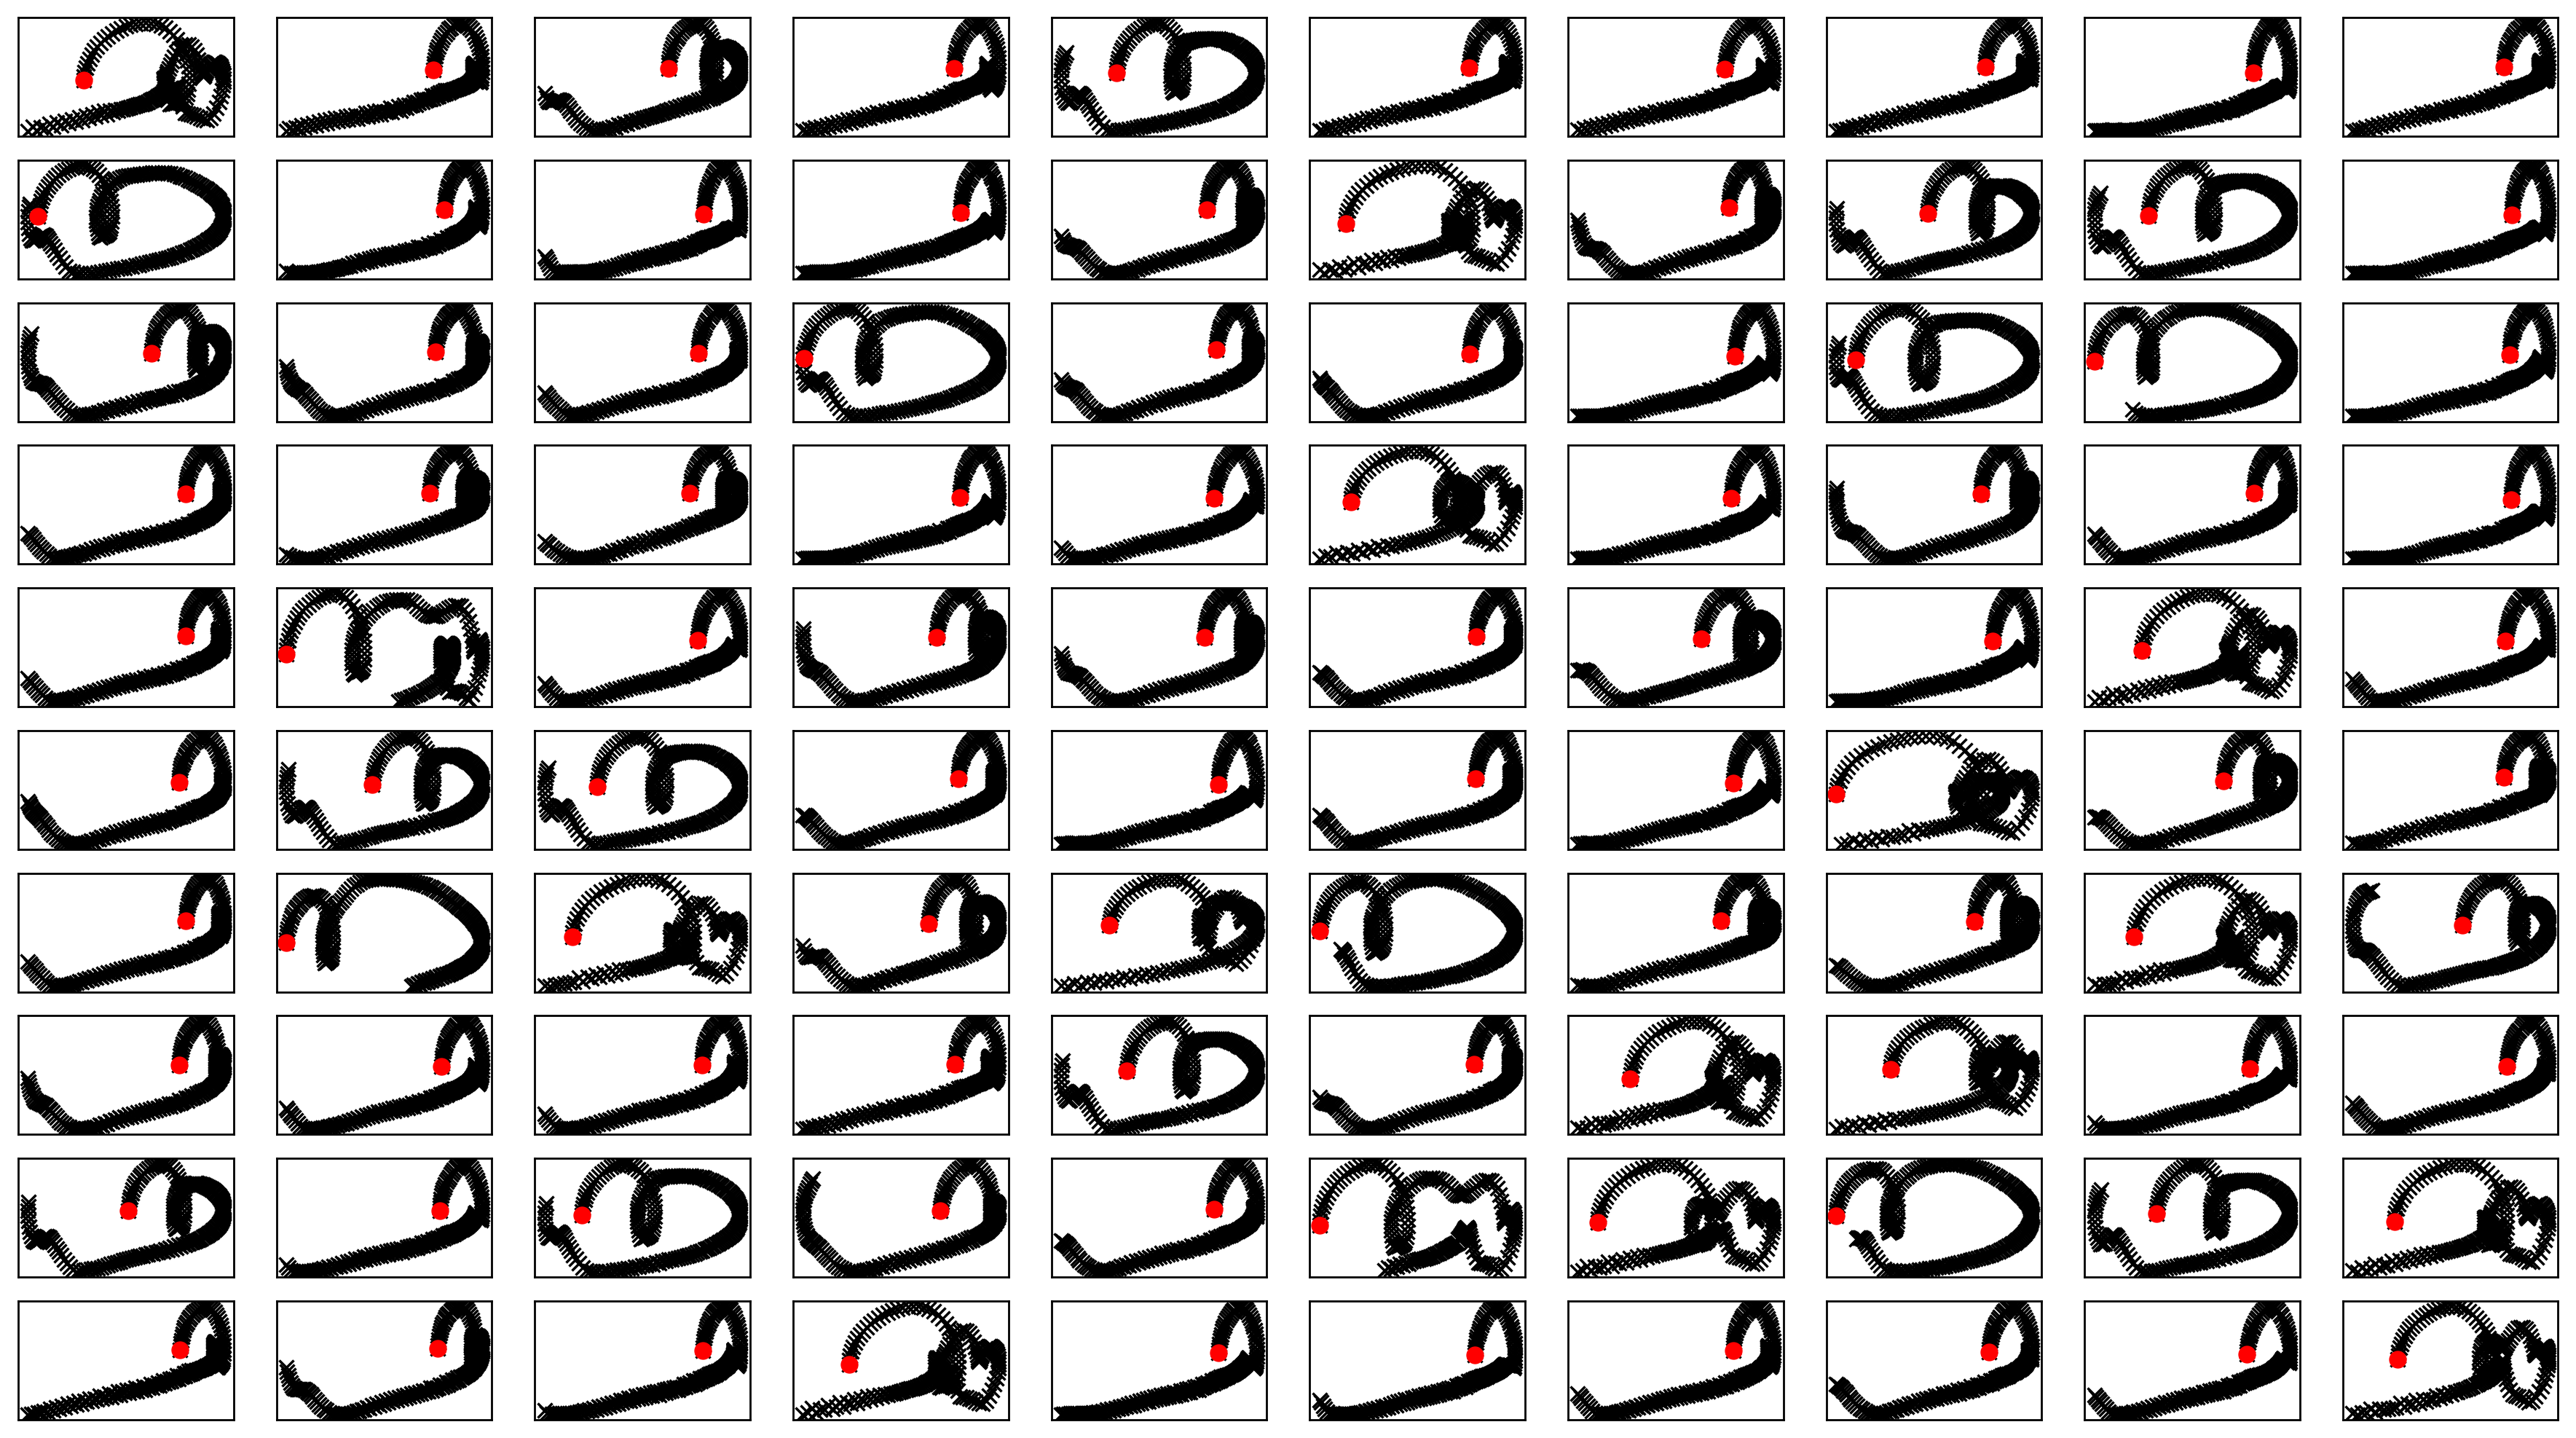

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

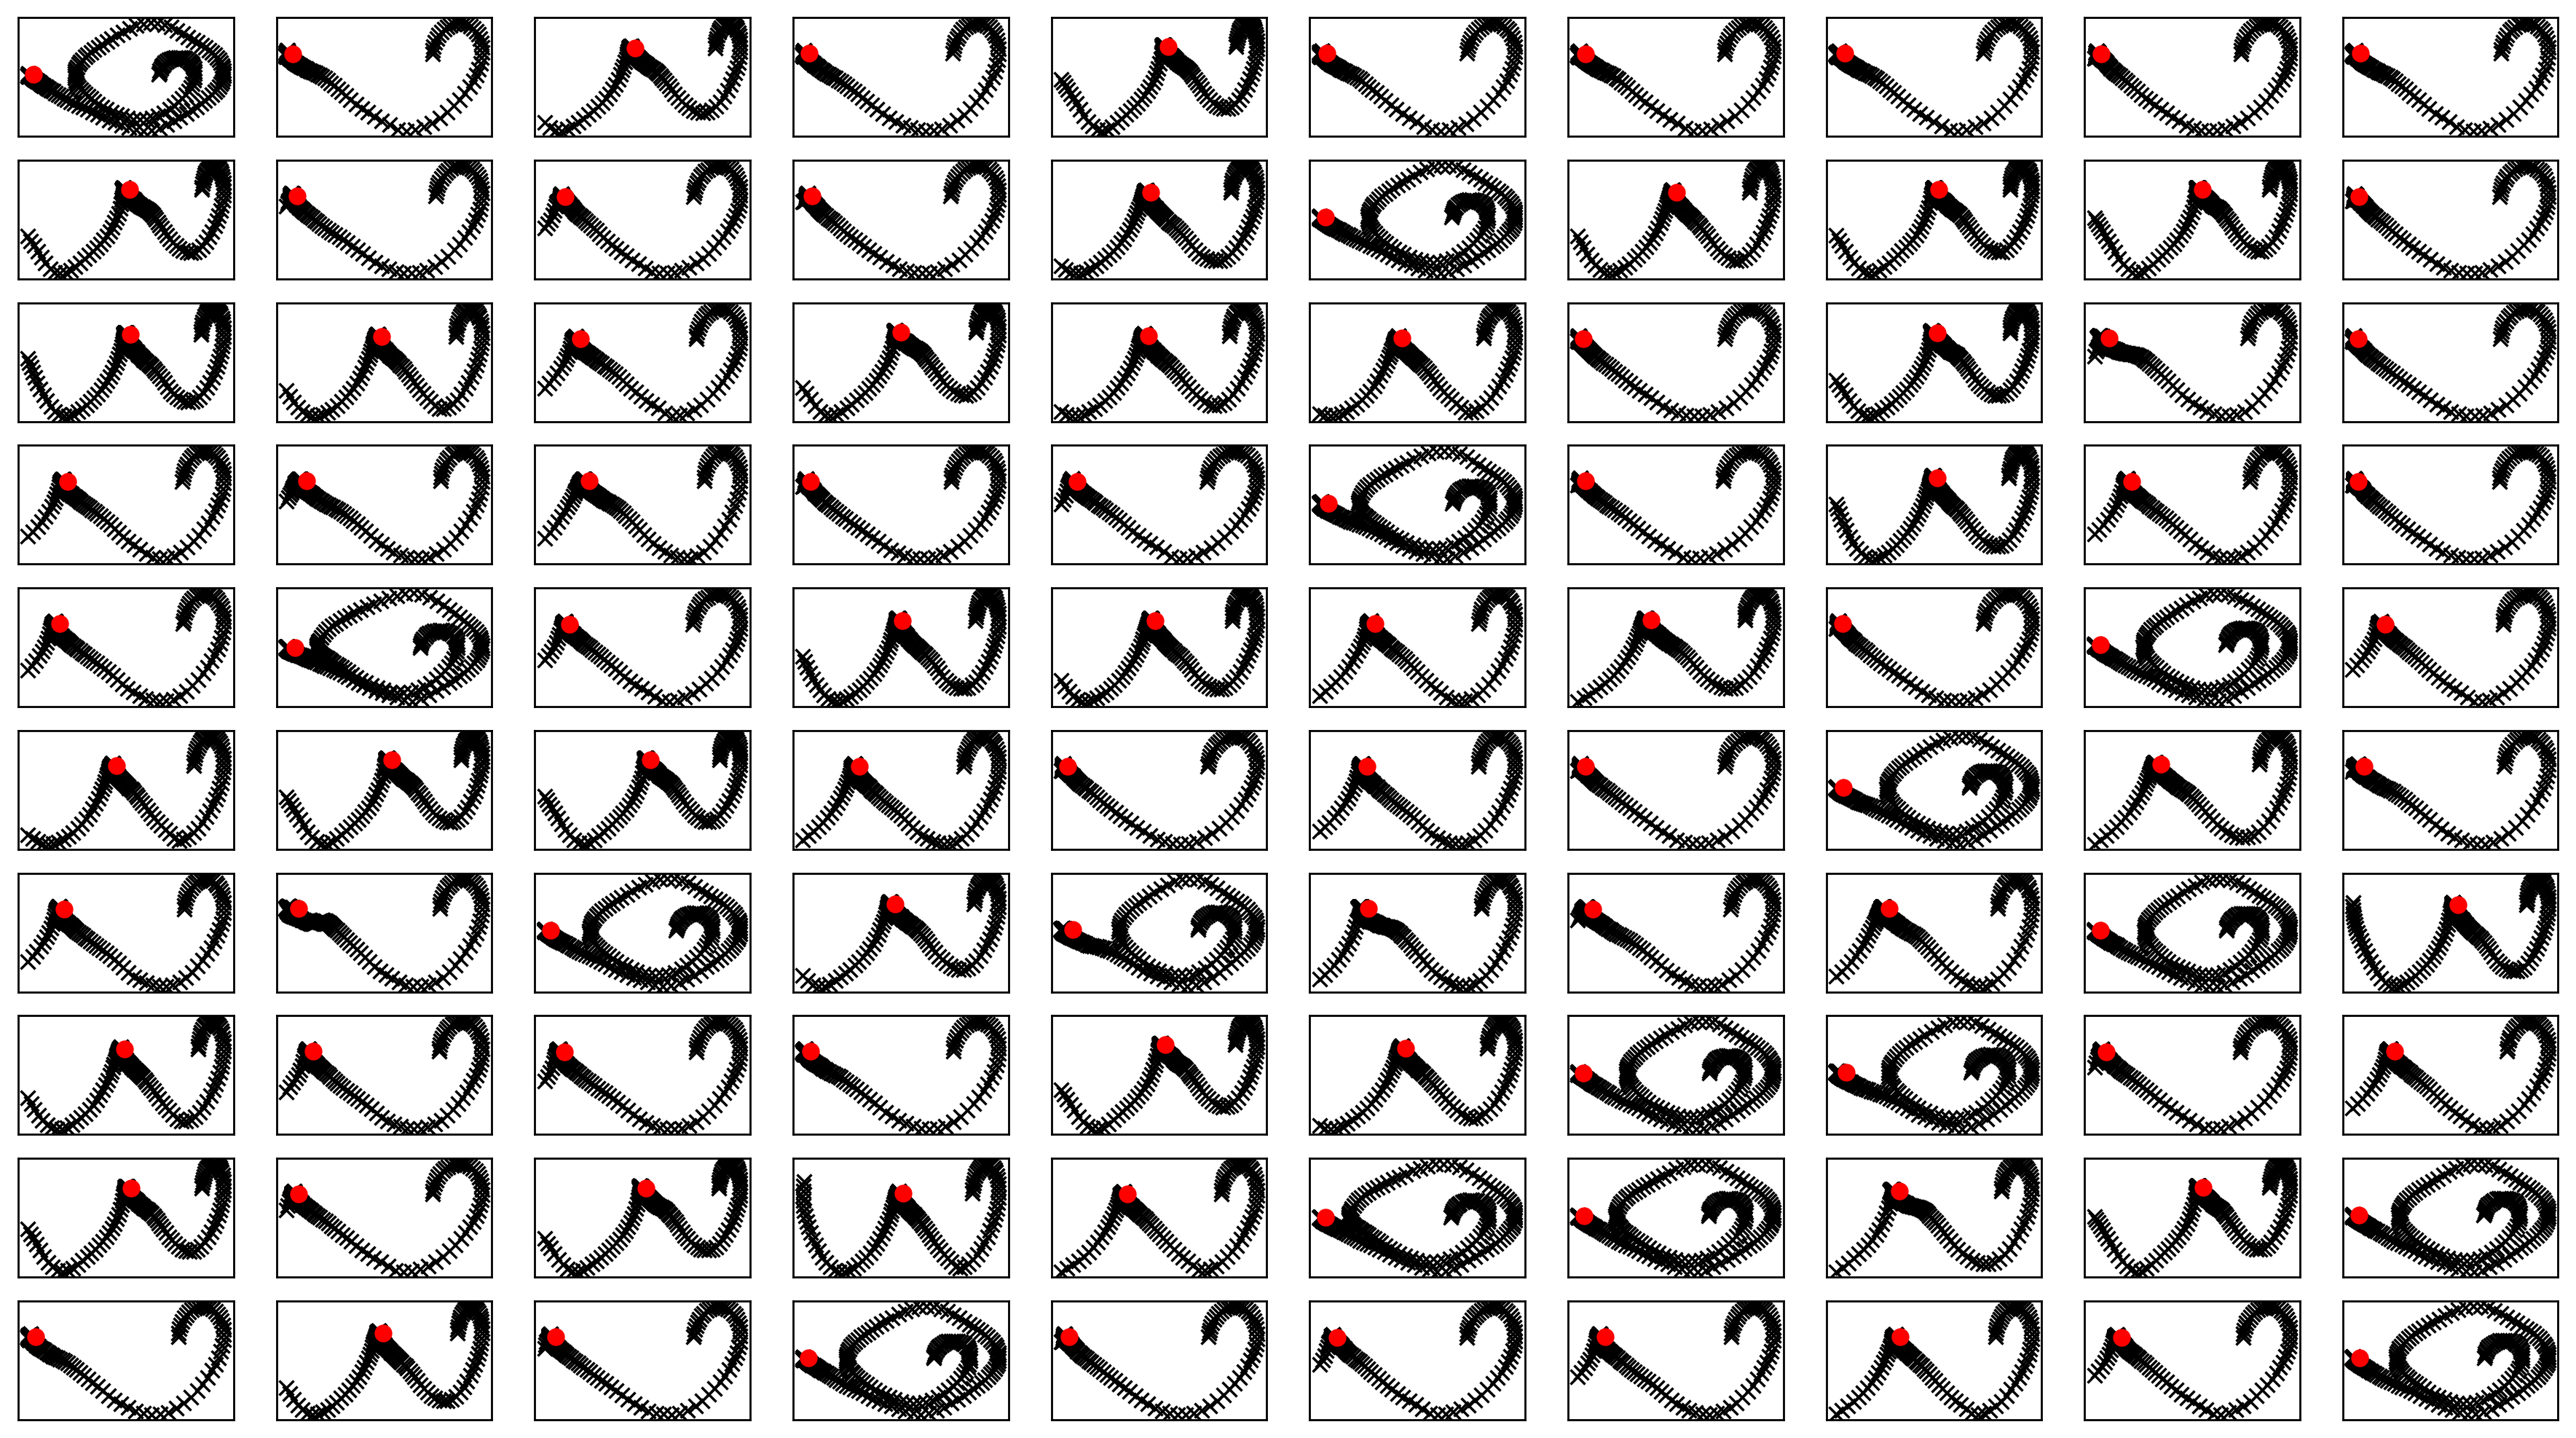

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-04 19:33:32.491235


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36285  validloss 1.40919±0.00000  bestvalidloss 1.40919  last_update 0
train: iter 1  trainloss 1.29344  validloss 1.29588±0.00000  bestvalidloss 1.29588  last_update 0
train: iter 2  trainloss 1.19889  validloss 1.17535±0.00000  bestvalidloss 1.17535  last_update 0
train: iter 3  trainloss 1.12784  validloss 1.06701±0.00000  bestvalidloss 1.06701  last_update 0
train: iter 4  trainloss 1.07227  validloss 1.02007±0.00000  bestvalidloss 1.02007  last_update 0
train: iter 5  trainloss 1.00949  validloss 0.95443±0.00000  bestvalidloss 0.95443  last_update 0
train: iter 6  trainloss 0.95886  validloss 0.89516±0.00000  bestvalidloss 0.89516  last_update 0
train: iter 7  trainloss 0.90408  validloss 0.82696±0.00000  bestvalidloss 0.82696  last_update 0
train: iter 8  trainloss 0.86385  validloss 0.80967±0.00000  bestvalidloss 0.80967  last_update 0
train: iter 9  trainloss 0.83530  validloss 0.75676±0.00000  bestvalidloss 0.75676  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.60398  validloss 0.57182±0.00000  bestvalidloss 0.56101  last_update 1
train: iter 84  trainloss 0.60482  validloss 0.58157±0.00000  bestvalidloss 0.56101  last_update 2
train: iter 85  trainloss 0.60363  validloss 0.56898±0.00000  bestvalidloss 0.56101  last_update 3
train: iter 86  trainloss 0.60912  validloss 0.56049±0.00000  bestvalidloss 0.56049  last_update 0
train: iter 87  trainloss 0.60656  validloss 0.57203±0.00000  bestvalidloss 0.56049  last_update 1
train: iter 88  trainloss 0.60210  validloss 0.57863±0.00000  bestvalidloss 0.56049  last_update 2
train: iter 89  trainloss 0.60136  validloss 0.57931±0.00000  bestvalidloss 0.56049  last_update 3
train: iter 90  trainloss 0.60235  validloss 0.57722±0.00000  bestvalidloss 0.56049  last_update 4
train: iter 91  trainloss 0.59747  validloss 0.56932±0.00000  bestvalidloss 0.56049  last_update 5
train: iter 92  trainloss 0.59780  validloss 0.57244±0.00000  bestvalidloss 0.56049  last_update 6
train: ite

train: iter 166  trainloss 0.55313  validloss 0.55236±0.00000  bestvalidloss 0.53727  last_update 6
train: iter 167  trainloss 0.54915  validloss 0.53863±0.00000  bestvalidloss 0.53727  last_update 7
train: iter 168  trainloss 0.55197  validloss 0.54769±0.00000  bestvalidloss 0.53727  last_update 8
train: iter 169  trainloss 0.55954  validloss 0.54747±0.00000  bestvalidloss 0.53727  last_update 9
train: iter 170  trainloss 0.55853  validloss 0.54307±0.00000  bestvalidloss 0.53727  last_update 10
train: iter 171  trainloss 0.55148  validloss 0.53444±0.00000  bestvalidloss 0.53444  last_update 0
train: iter 172  trainloss 0.55142  validloss 0.54284±0.00000  bestvalidloss 0.53444  last_update 1
train: iter 173  trainloss 0.55296  validloss 0.57252±0.00000  bestvalidloss 0.53444  last_update 2
train: iter 174  trainloss 0.55764  validloss 0.55631±0.00000  bestvalidloss 0.53444  last_update 3
train: iter 175  trainloss 0.55010  validloss 0.53546±0.00000  bestvalidloss 0.53444  last_update 4

train: iter 248  trainloss 0.51139  validloss 0.54757±0.00000  bestvalidloss 0.51960  last_update 6
train: iter 249  trainloss 0.51157  validloss 0.52467±0.00000  bestvalidloss 0.51960  last_update 7
train: iter 250  trainloss 0.51477  validloss 0.52879±0.00000  bestvalidloss 0.51960  last_update 8
train: iter 251  trainloss 0.51490  validloss 0.52350±0.00000  bestvalidloss 0.51960  last_update 9
train: iter 252  trainloss 0.51061  validloss 0.53010±0.00000  bestvalidloss 0.51960  last_update 10
train: iter 253  trainloss 0.51276  validloss 0.53045±0.00000  bestvalidloss 0.51960  last_update 11
train: iter 254  trainloss 0.52051  validloss 0.52271±0.00000  bestvalidloss 0.51960  last_update 12
train: iter 255  trainloss 0.51385  validloss 0.54007±0.00000  bestvalidloss 0.51960  last_update 13
train: iter 256  trainloss 0.52126  validloss 0.52536±0.00000  bestvalidloss 0.51960  last_update 14
train: iter 257  trainloss 0.51211  validloss 0.52861±0.00000  bestvalidloss 0.51960  last_upda

train: iter 330  trainloss 0.48421  validloss 0.50987±0.00000  bestvalidloss 0.50625  last_update 5
train: iter 331  trainloss 0.48562  validloss 0.52574±0.00000  bestvalidloss 0.50625  last_update 6
train: iter 332  trainloss 0.47962  validloss 0.51706±0.00000  bestvalidloss 0.50625  last_update 7
train: iter 333  trainloss 0.48189  validloss 0.52312±0.00000  bestvalidloss 0.50625  last_update 8
train: iter 334  trainloss 0.47823  validloss 0.55371±0.00000  bestvalidloss 0.50625  last_update 9
train: iter 335  trainloss 0.49543  validloss 0.51466±0.00000  bestvalidloss 0.50625  last_update 10
train: iter 336  trainloss 0.49440  validloss 0.58481±0.00000  bestvalidloss 0.50625  last_update 11
train: iter 337  trainloss 0.48159  validloss 0.51287±0.00000  bestvalidloss 0.50625  last_update 12
train: iter 338  trainloss 0.49203  validloss 0.56517±0.00000  bestvalidloss 0.50625  last_update 13
train: iter 339  trainloss 0.48081  validloss 0.50822±0.00000  bestvalidloss 0.50625  last_updat

train: iter 412  trainloss 0.47208  validloss 0.50408±0.00000  bestvalidloss 0.49379  last_update 7
train: iter 413  trainloss 0.47310  validloss 0.58792±0.00000  bestvalidloss 0.49379  last_update 8
train: iter 414  trainloss 0.45407  validloss 0.50248±0.00000  bestvalidloss 0.49379  last_update 9
train: iter 415  trainloss 0.45765  validloss 0.50710±0.00000  bestvalidloss 0.49379  last_update 10
train: iter 416  trainloss 0.45613  validloss 0.49848±0.00000  bestvalidloss 0.49379  last_update 11
train: iter 417  trainloss 0.45892  validloss 0.51027±0.00000  bestvalidloss 0.49379  last_update 12
train: iter 418  trainloss 0.45941  validloss 0.50023±0.00000  bestvalidloss 0.49379  last_update 13
train: iter 419  trainloss 0.46270  validloss 0.50801±0.00000  bestvalidloss 0.49379  last_update 14
train: iter 420  trainloss 0.45601  validloss 0.53306±0.00000  bestvalidloss 0.49379  last_update 15
train: iter 421  trainloss 0.46184  validloss 0.51124±0.00000  bestvalidloss 0.49379  last_upd

train: iter 494  trainloss 0.43935  validloss 0.50997±0.00000  bestvalidloss 0.48275  last_update 8
train: iter 495  trainloss 0.44372  validloss 0.48910±0.00000  bestvalidloss 0.48275  last_update 9
train: iter 496  trainloss 0.44031  validloss 0.49795±0.00000  bestvalidloss 0.48275  last_update 10
train: iter 497  trainloss 0.44266  validloss 0.51520±0.00000  bestvalidloss 0.48275  last_update 11
train: iter 498  trainloss 0.45165  validloss 0.49267±0.00000  bestvalidloss 0.48275  last_update 12
train: iter 499  trainloss 0.44176  validloss 0.51175±0.00000  bestvalidloss 0.48275  last_update 13
train: iter 500  trainloss 0.44587  validloss 0.48677±0.00000  bestvalidloss 0.48275  last_update 14
train: iter 501  trainloss 0.43973  validloss 0.49357±0.00000  bestvalidloss 0.48275  last_update 15
train: iter 502  trainloss 0.43819  validloss 0.48814±0.00000  bestvalidloss 0.48275  last_update 16
train: iter 503  trainloss 0.44308  validloss 0.51873±0.00000  bestvalidloss 0.48275  last_up

train: iter 576  trainloss 0.42938  validloss 0.48916±0.00000  bestvalidloss 0.47271  last_update 16
train: iter 577  trainloss 0.42856  validloss 0.48396±0.00000  bestvalidloss 0.47271  last_update 17
train: iter 578  trainloss 0.42944  validloss 0.47948±0.00000  bestvalidloss 0.47271  last_update 18
train: iter 579  trainloss 0.42770  validloss 0.49381±0.00000  bestvalidloss 0.47271  last_update 19
train: iter 580  trainloss 0.42426  validloss 0.49869±0.00000  bestvalidloss 0.47271  last_update 20
train: iter 581  trainloss 0.43002  validloss 0.49397±0.00000  bestvalidloss 0.47271  last_update 21
train: iter 582  trainloss 0.43042  validloss 0.47125±0.00000  bestvalidloss 0.47125  last_update 0
train: iter 583  trainloss 0.42597  validloss 0.50803±0.00000  bestvalidloss 0.47125  last_update 1
train: iter 584  trainloss 0.42408  validloss 0.47272±0.00000  bestvalidloss 0.47125  last_update 2
train: iter 585  trainloss 0.43162  validloss 0.48806±0.00000  bestvalidloss 0.47125  last_upd

train: iter 658  trainloss 0.41969  validloss 0.46538±0.00000  bestvalidloss 0.46298  last_update 9
train: iter 659  trainloss 0.41627  validloss 0.46737±0.00000  bestvalidloss 0.46298  last_update 10
train: iter 660  trainloss 0.41137  validloss 0.47861±0.00000  bestvalidloss 0.46298  last_update 11
train: iter 661  trainloss 0.41215  validloss 0.46984±0.00000  bestvalidloss 0.46298  last_update 12
train: iter 662  trainloss 0.42761  validloss 0.52738±0.00000  bestvalidloss 0.46298  last_update 13
train: iter 663  trainloss 0.41682  validloss 0.47707±0.00000  bestvalidloss 0.46298  last_update 14
train: iter 664  trainloss 0.41478  validloss 0.50197±0.00000  bestvalidloss 0.46298  last_update 15
train: iter 665  trainloss 0.41622  validloss 0.49000±0.00000  bestvalidloss 0.46298  last_update 16
train: iter 666  trainloss 0.40972  validloss 0.48464±0.00000  bestvalidloss 0.46298  last_update 17
train: iter 667  trainloss 0.41121  validloss 0.49600±0.00000  bestvalidloss 0.46298  last_u

train: iter 740  trainloss 0.40305  validloss 0.48853±0.00000  bestvalidloss 0.45709  last_update 46
train: iter 741  trainloss 0.40090  validloss 0.47936±0.00000  bestvalidloss 0.45709  last_update 47
train: iter 742  trainloss 0.40278  validloss 0.47169±0.00000  bestvalidloss 0.45709  last_update 48
train: iter 743  trainloss 0.41078  validloss 0.46505±0.00000  bestvalidloss 0.45709  last_update 49
train: iter 744  trainloss 0.40669  validloss 0.46599±0.00000  bestvalidloss 0.45709  last_update 50
train: iter 745  trainloss 0.41506  validloss 0.46777±0.00000  bestvalidloss 0.45709  last_update 51
train: iter 746  trainloss 0.42190  validloss 0.59869±0.00000  bestvalidloss 0.45709  last_update 52
train: iter 747  trainloss 0.40456  validloss 0.46835±0.00000  bestvalidloss 0.45709  last_update 53
train: iter 748  trainloss 0.40385  validloss 0.45930±0.00000  bestvalidloss 0.45709  last_update 54
train: iter 749  trainloss 0.41008  validloss 0.46129±0.00000  bestvalidloss 0.45709  last_

train: iter 822  trainloss 0.39426  validloss 0.50809±0.00000  bestvalidloss 0.45456  last_update 22
train: iter 823  trainloss 0.39362  validloss 0.49563±0.00000  bestvalidloss 0.45456  last_update 23
train: iter 824  trainloss 0.39629  validloss 0.49950±0.00000  bestvalidloss 0.45456  last_update 24
train: iter 825  trainloss 0.39174  validloss 0.47040±0.00000  bestvalidloss 0.45456  last_update 25
train: iter 826  trainloss 0.39206  validloss 0.47346±0.00000  bestvalidloss 0.45456  last_update 26
train: iter 827  trainloss 0.39405  validloss 0.45786±0.00000  bestvalidloss 0.45456  last_update 27
train: iter 828  trainloss 0.39275  validloss 0.45597±0.00000  bestvalidloss 0.45456  last_update 28
train: iter 829  trainloss 0.39314  validloss 0.48028±0.00000  bestvalidloss 0.45456  last_update 29
train: iter 830  trainloss 0.39619  validloss 0.47774±0.00000  bestvalidloss 0.45456  last_update 30
train: iter 831  trainloss 0.39122  validloss 0.46715±0.00000  bestvalidloss 0.45456  last_

([1.3628457978367805,
  1.2934359639883042,
  1.1988933749496937,
  1.1278417699038983,
  1.0722652867436409,
  1.0094942670315503,
  0.9588613506406546,
  0.9040801405906678,
  0.8638548105955124,
  0.8352986156940461,
  0.8049853444099426,
  0.7862038295716047,
  0.7623856209218502,
  0.7558706570416689,
  0.7389996100217104,
  0.7325521800667048,
  0.727083396539092,
  0.7116492755711079,
  0.7187842141836882,
  0.7069589477032423,
  0.6999131597578525,
  0.6971560604870319,
  0.6923668246716261,
  0.684719318896532,
  0.6878969501703978,
  0.6809909291565418,
  0.6804829757660628,
  0.67955861389637,
  0.6694645471870899,
  0.678224533982575,
  0.6659136444330216,
  0.6611835177987814,
  0.6692621015012264,
  0.668965420499444,
  0.6539917342364788,
  0.6578633036464453,
  0.6560522761195898,
  0.6607127003371716,
  0.659054908156395,
  0.6523601990193129,
  0.6520125089213252,
  0.6537297111004591,
  0.6469917841255665,
  0.6466222863644362,
  0.6397242922335863,
  0.6530944013968

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.829062398850917
valid_loss:  -4.2484386390686035
weight_alpha 1.0 h_min_tilde -12.098343 ell_tilde -4.712937646894455 kappa_tilde 0.00036797035743053733
train_loss:  -5.796969325447082
valid_loss:  -4.9937560157775875
weight_alpha 0.1 h_min_tilde -12.098343 ell_tilde -5.6363266635131835 kappa_tilde 0.0003933833529900269


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1130.81573  validloss -997.85703±0.00000  bestvalidloss -997.85703  last_update 0
train: iter 1  trainloss -1134.48468  validloss -974.47595±0.00000  bestvalidloss -997.85703  last_update 1
train: iter 2  trainloss -1138.63682  validloss -990.03514±0.00000  bestvalidloss -997.85703  last_update 2
train: iter 3  trainloss -1122.01062  validloss -927.50013±0.00000  bestvalidloss -997.85703  last_update 3
train: iter 4  trainloss -1131.37530  validloss -946.71342±0.00000  bestvalidloss -997.85703  last_update 4
train: iter 5  trainloss -1131.95817  validloss -969.71571±0.00000  bestvalidloss -997.85703  last_update 5
train: iter 6  trainloss -1132.22896  validloss -951.00616±0.00000  bestvalidloss -997.85703  last_update 6
train: iter 7  trainloss -1140.00597  validloss -964.22097±0.00000  bestvalidloss -997.85703  last_update 7
train: iter 8  trainloss -1132.62777  validloss -958.96005±0.00000  bestvalidloss -997.8570

train: iter 75  trainloss -1146.45228  validloss -954.23033±0.00000  bestvalidloss -997.85703  last_update 75
train: iter 76  trainloss -1143.63941  validloss -961.50021±0.00000  bestvalidloss -997.85703  last_update 76
train: iter 77  trainloss -1127.09660  validloss -943.19398±0.00000  bestvalidloss -997.85703  last_update 77
train: iter 78  trainloss -1140.75045  validloss -906.61861±0.00000  bestvalidloss -997.85703  last_update 78
train: iter 79  trainloss -1128.59639  validloss -941.85837±0.00000  bestvalidloss -997.85703  last_update 79
train: iter 80  trainloss -1161.66344  validloss -940.13344±0.00000  bestvalidloss -997.85703  last_update 80
train: iter 81  trainloss -1152.31299  validloss -973.82000±0.00000  bestvalidloss -997.85703  last_update 81
train: iter 82  trainloss -1154.70632  validloss -939.03199±0.00000  bestvalidloss -997.85703  last_update 82
train: iter 83  trainloss -1153.37309  validloss -961.08433±0.00000  bestvalidloss -997.85703  last_update 83
train: ite

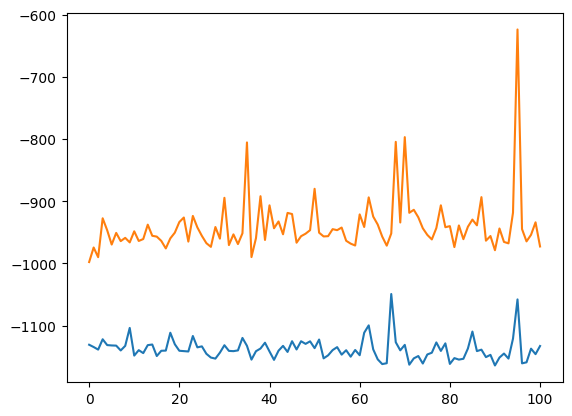

alpha 0.1 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-04 20:01:27.646874


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.49420  validloss 0.53526±0.00000  bestvalidloss 0.53526  last_update 0
train: iter 1  trainloss 0.47502  validloss 0.45717±0.00000  bestvalidloss 0.45717  last_update 0
train: iter 2  trainloss 0.47171  validloss 0.45934±0.00000  bestvalidloss 0.45717  last_update 1
train: iter 3  trainloss 0.46493  validloss 0.50317±0.00000  bestvalidloss 0.45717  last_update 2
train: iter 4  trainloss 0.47527  validloss 0.45868±0.00000  bestvalidloss 0.45717  last_update 3
train: iter 5  trainloss 0.45996  validloss 0.46283±0.00000  bestvalidloss 0.45717  last_update 4
train: iter 6  trainloss 0.46303  validloss 0.49080±0.00000  bestvalidloss 0.45717  last_update 5
train: iter 7  trainloss 0.46038  validloss 0.46439±0.00000  bestvalidloss 0.45717  last_update 6
train: iter 8  trainloss 0.45532  validloss 0.47049±0.00000  bestvalidloss 0.45717  last_update 7
train: iter 9  trainloss 0.46083  validloss 0.46864±0.00000  bestvalidloss 0.45717  last_update 8
train: iter 10  trai

train: iter 83  trainloss 0.39382  validloss 0.47548±0.00000  bestvalidloss 0.44207  last_update 63
train: iter 84  trainloss 0.39405  validloss 0.45298±0.00000  bestvalidloss 0.44207  last_update 64
train: iter 85  trainloss 0.39245  validloss 0.45894±0.00000  bestvalidloss 0.44207  last_update 65
train: iter 86  trainloss 0.38946  validloss 0.44496±0.00000  bestvalidloss 0.44207  last_update 66
train: iter 87  trainloss 0.38870  validloss 0.44395±0.00000  bestvalidloss 0.44207  last_update 67
train: iter 88  trainloss 0.39051  validloss 0.46040±0.00000  bestvalidloss 0.44207  last_update 68
train: iter 89  trainloss 0.39212  validloss 0.45575±0.00000  bestvalidloss 0.44207  last_update 69
train: iter 90  trainloss 0.39497  validloss 0.44692±0.00000  bestvalidloss 0.44207  last_update 70
train: iter 91  trainloss 0.38968  validloss 0.44958±0.00000  bestvalidloss 0.44207  last_update 71
train: iter 92  trainloss 0.38491  validloss 0.45036±0.00000  bestvalidloss 0.44207  last_update 72


train: iter 165  trainloss 0.37744  validloss 0.45627±0.00000  bestvalidloss 0.44087  last_update 8
train: iter 166  trainloss 0.37194  validloss 0.45779±0.00000  bestvalidloss 0.44087  last_update 9
train: iter 167  trainloss 0.37569  validloss 0.46074±0.00000  bestvalidloss 0.44087  last_update 10
train: iter 168  trainloss 0.36837  validloss 0.44950±0.00000  bestvalidloss 0.44087  last_update 11
train: iter 169  trainloss 0.36692  validloss 0.44818±0.00000  bestvalidloss 0.44087  last_update 12
train: iter 170  trainloss 0.36553  validloss 0.45930±0.00000  bestvalidloss 0.44087  last_update 13
train: iter 171  trainloss 0.37144  validloss 0.44214±0.00000  bestvalidloss 0.44087  last_update 14
train: iter 172  trainloss 0.37199  validloss 0.43773±0.00000  bestvalidloss 0.43773  last_update 0
train: iter 173  trainloss 0.36938  validloss 0.45614±0.00000  bestvalidloss 0.43773  last_update 1
train: iter 174  trainloss 0.36865  validloss 0.44550±0.00000  bestvalidloss 0.43773  last_upda

train: iter 247  trainloss 0.35520  validloss 0.44446±0.00000  bestvalidloss 0.43643  last_update 4
train: iter 248  trainloss 0.35011  validloss 0.46579±0.00000  bestvalidloss 0.43643  last_update 5
train: iter 249  trainloss 0.35158  validloss 0.45889±0.00000  bestvalidloss 0.43643  last_update 6
train: iter 250  trainloss 0.35283  validloss 0.45506±0.00000  bestvalidloss 0.43643  last_update 7
train: iter 251  trainloss 0.35450  validloss 0.44190±0.00000  bestvalidloss 0.43643  last_update 8
train: iter 252  trainloss 0.35736  validloss 0.43851±0.00000  bestvalidloss 0.43643  last_update 9
train: iter 253  trainloss 0.34971  validloss 0.46624±0.00000  bestvalidloss 0.43643  last_update 10
train: iter 254  trainloss 0.34868  validloss 0.44872±0.00000  bestvalidloss 0.43643  last_update 11
train: iter 255  trainloss 0.34892  validloss 0.44750±0.00000  bestvalidloss 0.43643  last_update 12
train: iter 256  trainloss 0.35211  validloss 0.47292±0.00000  bestvalidloss 0.43643  last_update

train: iter 329  trainloss 0.33510  validloss 0.44449±0.00000  bestvalidloss 0.43438  last_update 5
train: iter 330  trainloss 0.33545  validloss 0.44055±0.00000  bestvalidloss 0.43438  last_update 6
train: iter 331  trainloss 0.33394  validloss 0.46560±0.00000  bestvalidloss 0.43438  last_update 7
train: iter 332  trainloss 0.33988  validloss 0.43614±0.00000  bestvalidloss 0.43438  last_update 8
train: iter 333  trainloss 0.33681  validloss 0.46243±0.00000  bestvalidloss 0.43438  last_update 9
train: iter 334  trainloss 0.33788  validloss 0.45903±0.00000  bestvalidloss 0.43438  last_update 10
train: iter 335  trainloss 0.33699  validloss 0.44743±0.00000  bestvalidloss 0.43438  last_update 11
train: iter 336  trainloss 0.34028  validloss 0.47158±0.00000  bestvalidloss 0.43438  last_update 12
train: iter 337  trainloss 0.33766  validloss 0.45469±0.00000  bestvalidloss 0.43438  last_update 13
train: iter 338  trainloss 0.33833  validloss 0.44183±0.00000  bestvalidloss 0.43438  last_updat

train: iter 411  trainloss 0.32172  validloss 0.44237±0.00000  bestvalidloss 0.43438  last_update 87
train: iter 412  trainloss 0.32655  validloss 0.46439±0.00000  bestvalidloss 0.43438  last_update 88
train: iter 413  trainloss 0.32608  validloss 0.44990±0.00000  bestvalidloss 0.43438  last_update 89
train: iter 414  trainloss 0.32638  validloss 0.45714±0.00000  bestvalidloss 0.43438  last_update 90
train: iter 415  trainloss 0.32319  validloss 0.43674±0.00000  bestvalidloss 0.43438  last_update 91
train: iter 416  trainloss 0.32340  validloss 0.48384±0.00000  bestvalidloss 0.43438  last_update 92
train: iter 417  trainloss 0.32652  validloss 0.45042±0.00000  bestvalidloss 0.43438  last_update 93
train: iter 418  trainloss 0.32797  validloss 0.46668±0.00000  bestvalidloss 0.43438  last_update 94
train: iter 419  trainloss 0.32788  validloss 0.47544±0.00000  bestvalidloss 0.43438  last_update 95
train: iter 420  trainloss 0.32332  validloss 0.45506±0.00000  bestvalidloss 0.43438  last_

([0.49420089554041624,
  0.47501773154363036,
  0.4717055606655777,
  0.4649252307601273,
  0.4752715554088354,
  0.45995817640796305,
  0.46302631925791504,
  0.4603778699412942,
  0.45531549518927933,
  0.460832950938493,
  0.4634649047628045,
  0.46907048737630247,
  0.4509496624581516,
  0.45455189077183605,
  0.4526940679177642,
  0.45320052076131107,
  0.4461051350459456,
  0.45601913463324306,
  0.4466003693640232,
  0.45265474673360584,
  0.4429354681633413,
  0.4307336029596627,
  0.4230598691850901,
  0.4219492546282709,
  0.42393638715147974,
  0.4182630074210465,
  0.4168546823784709,
  0.4219879411160946,
  0.416421093698591,
  0.4117518147453666,
  0.4170975061133504,
  0.4112719881348312,
  0.4121583075262606,
  0.41267725061625243,
  0.40939516816288235,
  0.4089736555702984,
  0.4124553189612925,
  0.41547615686431527,
  0.41060462417081,
  0.4065615450963378,
  0.40842067496851087,
  0.40895740007981657,
  0.4036560125648975,
  0.405690323933959,
  0.4065902281552553,

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.442866522255541
valid_loss:  -7.8481169602155685
weight_alpha 1.0 h_min_tilde -11.885042 ell_tilde -5.923916609847547 kappa_tilde 0.0004095772865576352
train_loss:  -5.5638656852722175
valid_loss:  -4.920474913024902
weight_alpha 0.1 h_min_tilde -11.885042 ell_tilde -5.435187530822755 kappa_tilde 0.00039375405180799286


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1113.24184  validloss -984.31526±0.00000  bestvalidloss -984.31526  last_update 0
train: iter 1  trainloss -1055.51659  validloss -943.25252±0.00000  bestvalidloss -984.31526  last_update 1
train: iter 2  trainloss -1092.49814  validloss -915.79890±0.00000  bestvalidloss -984.31526  last_update 2
train: iter 3  trainloss -1109.69390  validloss -974.27158±0.00000  bestvalidloss -984.31526  last_update 3
train: iter 4  trainloss -1094.36478  validloss -966.39268±0.00000  bestvalidloss -984.31526  last_update 4
train: iter 5  trainloss -1110.58110  validloss -956.51471±0.00000  bestvalidloss -984.31526  last_update 5
train: iter 6  trainloss -1062.78219  validloss -933.84414±0.00000  bestvalidloss -984.31526  last_update 6
train: iter 7  trainloss -1083.61687  validloss -933.41435±0.00000  bestvalidloss -984.31526  last_update 7
train: iter 8  trainloss -1103.50141  validloss -949.44761±0.00000  bestvalidloss -984.3152

train: iter 75  trainloss -1121.29209  validloss -929.83411±0.00000  bestvalidloss -984.31526  last_update 75
train: iter 76  trainloss -1136.41378  validloss -952.76602±0.00000  bestvalidloss -984.31526  last_update 76
train: iter 77  trainloss -1121.37140  validloss -937.17959±0.00000  bestvalidloss -984.31526  last_update 77
train: iter 78  trainloss -1087.68191  validloss -955.57188±0.00000  bestvalidloss -984.31526  last_update 78
train: iter 79  trainloss -1086.26284  validloss -912.87434±0.00000  bestvalidloss -984.31526  last_update 79
train: iter 80  trainloss -1126.38984  validloss -958.62004±0.00000  bestvalidloss -984.31526  last_update 80
train: iter 81  trainloss -1139.59293  validloss -906.59090±0.00000  bestvalidloss -984.31526  last_update 81
train: iter 82  trainloss -1102.48852  validloss -974.80691±0.00000  bestvalidloss -984.31526  last_update 82
train: iter 83  trainloss -1117.97745  validloss -960.39382±0.00000  bestvalidloss -984.31526  last_update 83
train: ite

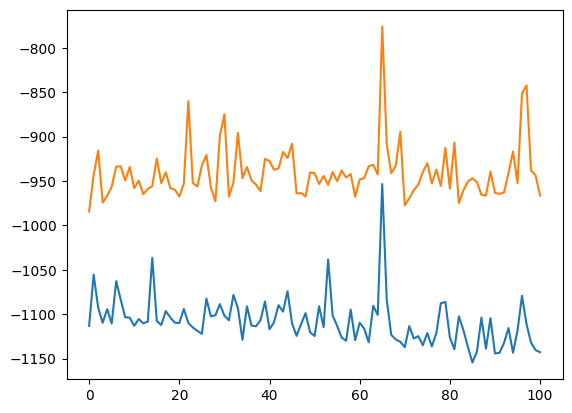

alpha 0.1 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-04 20:22:35.855387


Text(0, 0.5, 'loss')

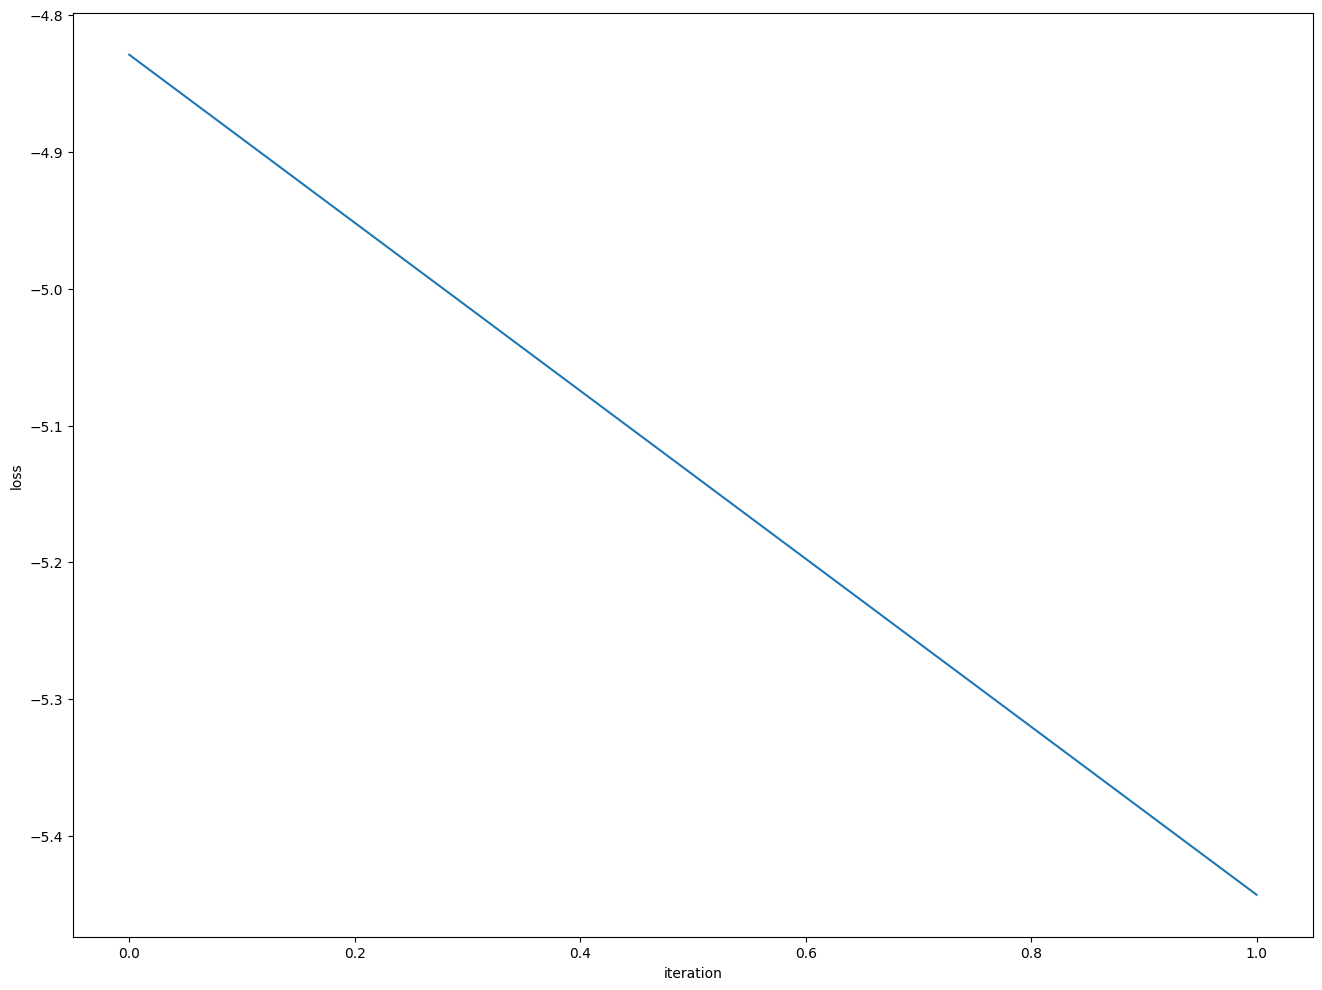

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

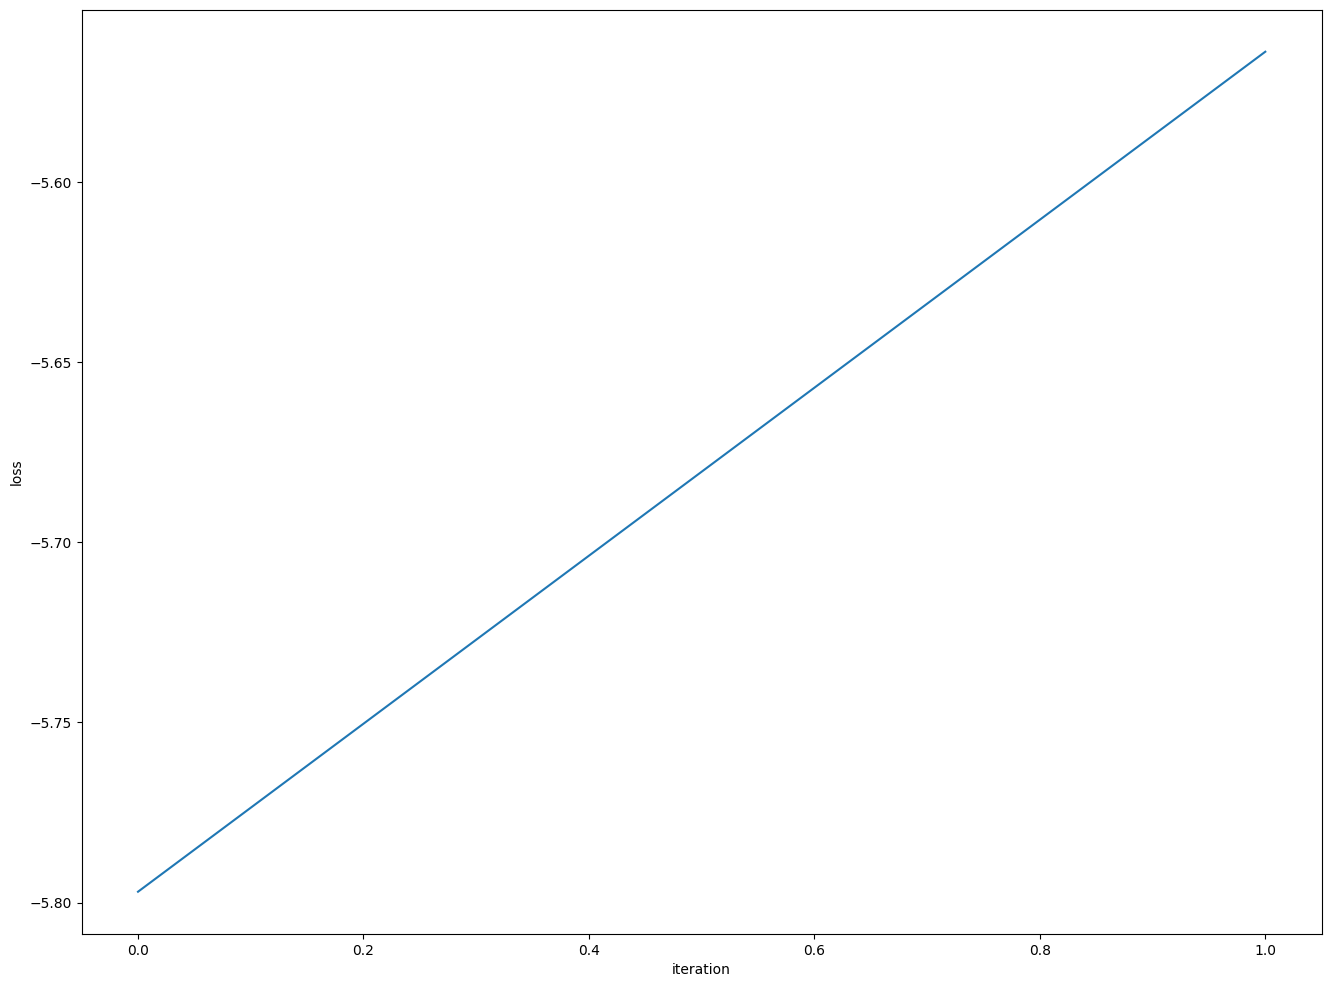

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.46854  validloss 0.60987±0.00000  bestvalidloss 0.60987  last_update 0
train: iter 1  trainloss 0.43019  validloss 0.48736±0.00000  bestvalidloss 0.48736  last_update 0
train: iter 2  trainloss 0.42008  validloss 0.48603±0.00000  bestvalidloss 0.48603  last_update 0
train: iter 3  trainloss 0.41615  validloss 0.47881±0.00000  bestvalidloss 0.47881  last_update 0
train: iter 4  trainloss 0.41260  validloss 0.46989±0.00000  bestvalidloss 0.46989  last_update 0
train: iter 5  trainloss 0.40841  validloss 0.46768±0.00000  bestvalidloss 0.46768  last_update 0
train: iter 6  trainloss 0.41177  validloss 0.45940±0.00000  bestvalidloss 0.45940  last_update 0
train: iter 7  trainloss 0.40164  validloss 0.47443±0.00000  bestvalidloss 0.45940  last_update 1
train: iter 8  trainloss 0.40914  validloss 0.47400±0.00000  bestvalidloss 0.45940  last_update 2
train: iter 9  trainloss 0.40138  validloss 0.47141±0.00000  bestvalidloss 0.45940  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.36347  validloss 0.44545±0.00000  bestvalidloss 0.43319  last_update 18
train: iter 84  trainloss 0.36912  validloss 0.47516±0.00000  bestvalidloss 0.43319  last_update 19
train: iter 85  trainloss 0.36788  validloss 0.44762±0.00000  bestvalidloss 0.43319  last_update 20
train: iter 86  trainloss 0.36600  validloss 0.46122±0.00000  bestvalidloss 0.43319  last_update 21
train: iter 87  trainloss 0.37118  validloss 0.46225±0.00000  bestvalidloss 0.43319  last_update 22
train: iter 88  trainloss 0.36556  validloss 0.46598±0.00000  bestvalidloss 0.43319  last_update 23
train: iter 89  trainloss 0.36803  validloss 0.45305±0.00000  bestvalidloss 0.43319  last_update 24
train: iter 90  trainloss 0.36506  validloss 0.45509±0.00000  bestvalidloss 0.43319  last_update 25
train: iter 91  trainloss 0.36731  validloss 0.51992±0.00000  bestvalidloss 0.43319  last_update 26
train: iter 92  trainloss 0.36450  validloss 0.45241±0.00000  bestvalidloss 0.43319  last_update 27


train: iter 165  trainloss 0.35059  validloss 0.45045±0.00000  bestvalidloss 0.43319  last_update 100
train: fin


([0.46854346301406624,
  0.4301945018582046,
  0.420076010748744,
  0.4161500001326203,
  0.4125991809181869,
  0.4084092159755528,
  0.411766395252198,
  0.40163581985980273,
  0.40914066759869455,
  0.40138076711446047,
  0.40225758105516435,
  0.39915440753102305,
  0.39783519981428983,
  0.3986250154674053,
  0.39443691205233333,
  0.39656845489516857,
  0.39542170651257036,
  0.3869969968684018,
  0.3915857132524252,
  0.3910474110394716,
  0.38808184266090395,
  0.393541750498116,
  0.38756155082955956,
  0.3860991560854018,
  0.39114386336877943,
  0.3868238219991326,
  0.3894859842024744,
  0.38707575844600794,
  0.38870282834395764,
  0.3884833429940045,
  0.38787384601309893,
  0.38422102546319364,
  0.3824026482179761,
  0.39258737647905945,
  0.38630827190354466,
  0.38459871681407093,
  0.3783749449066818,
  0.38137447237968447,
  0.38151011634618043,
  0.3860580582171679,
  0.38262966526672243,
  0.3773077419959009,
  0.3783912844955921,
  0.3755335691384971,
  0.37722197

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.4663867273002866
valid_loss:  -4.6050850317358965
weight_alpha 1.0 h_min_tilde -12.128126 ell_tilde -3.6941263881874082 kappa_tilde 0.00034433661667769225
train_loss:  -5.285884100532532
valid_loss:  -4.632970679283142
weight_alpha 0.1 h_min_tilde -12.128126 ell_tilde -5.155301416282653 kappa_tilde 0.0003787002794839636


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1045.90631  validloss -918.29716±0.00000  bestvalidloss -918.29716  last_update 0
train: iter 1  trainloss -1077.55342  validloss -911.45421±0.00000  bestvalidloss -918.29716  last_update 1
train: iter 2  trainloss -1077.78803  validloss -919.46157±0.00000  bestvalidloss -919.46157  last_update 0
train: iter 3  trainloss -1039.49835  validloss -868.92252±0.00000  bestvalidloss -919.46157  last_update 1
train: iter 4  trainloss -1063.86066  validloss -914.19879±0.00000  bestvalidloss -919.46157  last_update 2
train: iter 5  trainloss -1055.67778  validloss -933.58060±0.00000  bestvalidloss -933.58060  last_update 0
train: iter 6  trainloss -1034.68743  validloss -939.32524±0.00000  bestvalidloss -939.32524  last_update 0
train: iter 7  trainloss -1074.52912  validloss -929.47856±0.00000  bestvalidloss -939.32524  last_update 1
train: iter 8  trainloss -1080.02674  validloss -910.37613±0.00000  bestvalidloss -939.3252

train: iter 75  trainloss -1066.71538  validloss -824.89683±0.00000  bestvalidloss -977.28314  last_update 43
train: iter 76  trainloss -1076.24645  validloss -811.79528±0.00000  bestvalidloss -977.28314  last_update 44
train: iter 77  trainloss -1082.72793  validloss -878.42568±0.00000  bestvalidloss -977.28314  last_update 45
train: iter 78  trainloss -1079.11000  validloss -915.32272±0.00000  bestvalidloss -977.28314  last_update 46
train: iter 79  trainloss -1054.38804  validloss -921.24649±0.00000  bestvalidloss -977.28314  last_update 47
train: iter 80  trainloss -1076.95835  validloss -916.07727±0.00000  bestvalidloss -977.28314  last_update 48
train: iter 81  trainloss -1086.82155  validloss -920.33947±0.00000  bestvalidloss -977.28314  last_update 49
train: iter 82  trainloss -1080.56188  validloss -904.61159±0.00000  bestvalidloss -977.28314  last_update 50
train: iter 83  trainloss -1082.42784  validloss -925.16151±0.00000  bestvalidloss -977.28314  last_update 51
train: ite

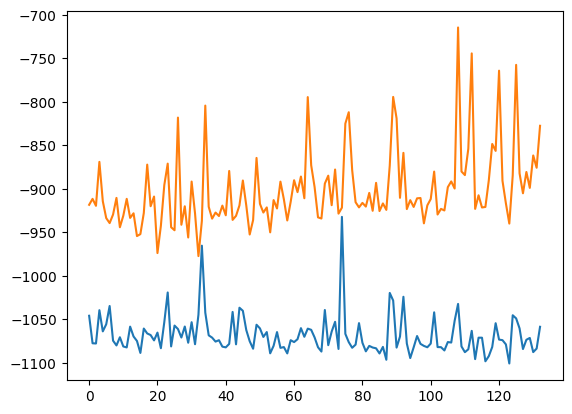

alpha 0.1 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-04 20:43:42.141575


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.57283  validloss 1.00973±0.00000  bestvalidloss 1.00973  last_update 0
train: iter 1  trainloss 0.53047  validloss 0.55589±0.00000  bestvalidloss 0.55589  last_update 0
train: iter 2  trainloss 0.51158  validloss 0.56270±0.00000  bestvalidloss 0.55589  last_update 1
train: iter 3  trainloss 0.50012  validloss 0.54767±0.00000  bestvalidloss 0.54767  last_update 0
train: iter 4  trainloss 0.50024  validloss 0.54533±0.00000  bestvalidloss 0.54533  last_update 0
train: iter 5  trainloss 0.48529  validloss 0.54146±0.00000  bestvalidloss 0.54146  last_update 0
train: iter 6  trainloss 0.49829  validloss 0.55276±0.00000  bestvalidloss 0.54146  last_update 1
train: iter 7  trainloss 0.48929  validloss 0.55012±0.00000  bestvalidloss 0.54146  last_update 2
train: iter 8  trainloss 0.48460  validloss 0.54548±0.00000  bestvalidloss 0.54146  last_update 3
train: iter 9  trainloss 0.48832  validloss 0.54871±0.00000  bestvalidloss 0.54146  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.43917  validloss 0.53648±0.00000  bestvalidloss 0.53061  last_update 25
train: iter 84  trainloss 0.43685  validloss 0.54245±0.00000  bestvalidloss 0.53061  last_update 26
train: iter 85  trainloss 0.44095  validloss 0.54647±0.00000  bestvalidloss 0.53061  last_update 27
train: iter 86  trainloss 0.43923  validloss 0.54378±0.00000  bestvalidloss 0.53061  last_update 28
train: iter 87  trainloss 0.44072  validloss 0.53403±0.00000  bestvalidloss 0.53061  last_update 29
train: iter 88  trainloss 0.43244  validloss 0.54394±0.00000  bestvalidloss 0.53061  last_update 30
train: iter 89  trainloss 0.43703  validloss 0.53318±0.00000  bestvalidloss 0.53061  last_update 31
train: iter 90  trainloss 0.43587  validloss 0.54695±0.00000  bestvalidloss 0.53061  last_update 32
train: iter 91  trainloss 0.43816  validloss 0.54792±0.00000  bestvalidloss 0.53061  last_update 33
train: iter 92  trainloss 0.44116  validloss 0.54394±0.00000  bestvalidloss 0.53061  last_update 34


([0.5728296976536512,
  0.5304684344679117,
  0.5115818738006055,
  0.500122545287013,
  0.5002383220940828,
  0.48529339786618947,
  0.4982896981760859,
  0.4892855918034911,
  0.48460469841957093,
  0.48831956963986156,
  0.4748395191505551,
  0.47610361110419036,
  0.4725645214319229,
  0.47527591194957497,
  0.4720869194716215,
  0.4716526819393039,
  0.46947639528661966,
  0.4736823195591569,
  0.47077111676335337,
  0.4659083494916558,
  0.465404512360692,
  0.47335264682769773,
  0.464067736081779,
  0.4628126725554466,
  0.47447412796318533,
  0.4739608365111053,
  0.46260870397090914,
  0.4633228784427047,
  0.45928130727261307,
  0.46661409381777047,
  0.45980714028701186,
  0.459713464602828,
  0.4591246807947755,
  0.45653077885508536,
  0.4602964805439115,
  0.45560880526900294,
  0.45580538678914306,
  0.4542318908497691,
  0.4580702969804406,
  0.45644755810499194,
  0.4532258078455925,
  0.4574950894340873,
  0.4575557503849268,
  0.4526400934904814,
  0.447112502716481

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.881896750608087
valid_loss:  -8.493695613622666
weight_alpha 1.0 h_min_tilde -12.191717 ell_tilde -6.404256523211002 kappa_tilde 0.00041567698116253124
train_loss:  -5.943788083124161
valid_loss:  -5.073452081871033
weight_alpha 0.1 h_min_tilde -12.191717 ell_tilde -5.769720882873536 kappa_tilde 0.0003946071732464168


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 158.47612  validloss 177.02150±0.00000  bestvalidloss 177.02150  last_update 0
train: iter 1  trainloss 126.05282  validloss 139.85709±0.00000  bestvalidloss 139.85709  last_update 0
train: iter 2  trainloss 100.66062  validloss 112.38831±0.00000  bestvalidloss 112.38831  last_update 0
train: iter 3  trainloss 81.54998  validloss 90.16448±0.00000  bestvalidloss 90.16448  last_update 0
train: iter 4  trainloss 66.59984  validloss 71.68212±0.00000  bestvalidloss 71.68212  last_update 0
train: iter 5  trainloss 54.50606  validloss 59.03937±0.00000  bestvalidloss 59.03937  last_update 0
train: iter 6  trainloss 44.50645  validloss 47.62293±0.00000  bestvalidloss 47.62293  last_update 0
train: iter 7  trainloss 36.22714  validloss 40.04286±0.00000  bestvalidloss 40.04286  last_update 0
train: iter 8  trainloss 30.06615  validloss 32.46141±0.00000  bestvalidloss 32.46141  last_update 0
train: iter 9  trainloss 24.68238  validloss 26.45979±0.00000  bestvalidloss 26.45

train: iter 85  trainloss -1.18973  validloss -1.17728±0.00000  bestvalidloss -1.21923  last_update 20
train: iter 86  trainloss -1.17587  validloss -1.09822±0.00000  bestvalidloss -1.21923  last_update 21
train: iter 87  trainloss -1.22474  validloss -1.04362±0.00000  bestvalidloss -1.21923  last_update 22
train: iter 88  trainloss -1.16975  validloss -1.14118±0.00000  bestvalidloss -1.21923  last_update 23
train: iter 89  trainloss -1.22982  validloss -1.18142±0.00000  bestvalidloss -1.21923  last_update 24
train: iter 90  trainloss -1.21873  validloss -1.12535±0.00000  bestvalidloss -1.21923  last_update 25
train: iter 91  trainloss -1.25524  validloss -1.10616±0.00000  bestvalidloss -1.21923  last_update 26
train: iter 92  trainloss -1.23247  validloss -1.11395±0.00000  bestvalidloss -1.21923  last_update 27
train: iter 93  trainloss -1.25163  validloss -1.18114±0.00000  bestvalidloss -1.21923  last_update 28
train: iter 94  trainloss -1.16454  validloss -1.17486±0.00000  bestvalid

train: iter 174  trainloss -1.23330  validloss -1.09463±0.00000  bestvalidloss -1.30060  last_update 68
train: iter 175  trainloss -1.20402  validloss -1.09756±0.00000  bestvalidloss -1.30060  last_update 69
train: iter 176  trainloss -1.22519  validloss -1.16504±0.00000  bestvalidloss -1.30060  last_update 70
train: iter 177  trainloss -1.23138  validloss -1.15878±0.00000  bestvalidloss -1.30060  last_update 71
train: iter 178  trainloss -1.22742  validloss -1.18327±0.00000  bestvalidloss -1.30060  last_update 72
train: iter 179  trainloss -1.22204  validloss -1.15155±0.00000  bestvalidloss -1.30060  last_update 73
train: iter 180  trainloss -1.23588  validloss -1.15727±0.00000  bestvalidloss -1.30060  last_update 74
train: iter 181  trainloss -1.22266  validloss -1.15875±0.00000  bestvalidloss -1.30060  last_update 75
train: iter 182  trainloss -1.17361  validloss -1.16314±0.00000  bestvalidloss -1.30060  last_update 76
train: iter 183  trainloss -1.25405  validloss -1.14254±0.00000 

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.9173, -1.5576, -4.3145, -3.8312], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.23511  validloss 15.14429±0.00000  bestvalidloss 15.14429  last_update 0
train: iter 1  trainloss 4.21077  validloss 14.48962±0.00000  bestvalidloss 14.48962  last_update 0
train: iter 2  trainloss 4.38531  validloss 13.87176±0.00000  bestvalidloss 13.87176  last_update 0
train: iter 3  trainloss 4.10291  validloss 14.79442±0.00000  bestvalidloss 13.87176  last_update 1
train: iter 4  trainloss 4.03259  validloss 14.92861±0.00000  bestvalidloss 13.87176  last_update 2
train: iter 5  trainloss 4.03831  validloss 14.56797±0.00000  bestvalidloss 13.87176  last_update 3
train: iter 6  trainloss 3.91175  validloss 15.18817±0.00000  bestvalidloss 13.87176  last_update 4
train: iter 7  trainloss 4.12331  validloss 14.23442±0.00000  bestvalidloss 13.87176  last_update 5
train: iter 8  trainloss 3.87507  validloss 14.94095±0.00000  bestvalidloss 13.87176  last_update 6
train: iter 9  trainloss 3.97573  validloss 14.56093±0.00000  bestvalidloss 13.87176  last_update 7


train: iter 81  trainloss 3.74490  validloss 15.27377±0.00000  bestvalidloss 12.65797  last_update 64
train: iter 82  trainloss 3.85972  validloss 15.92369±0.00000  bestvalidloss 12.65797  last_update 65
train: iter 83  trainloss 3.64035  validloss 14.81696±0.00000  bestvalidloss 12.65797  last_update 66
train: iter 84  trainloss 3.58351  validloss 16.07632±0.00000  bestvalidloss 12.65797  last_update 67
train: iter 85  trainloss 3.68343  validloss 15.13842±0.00000  bestvalidloss 12.65797  last_update 68
train: iter 86  trainloss 3.64177  validloss 15.71368±0.00000  bestvalidloss 12.65797  last_update 69
train: iter 87  trainloss 3.67353  validloss 14.09658±0.00000  bestvalidloss 12.65797  last_update 70
train: iter 88  trainloss 3.69634  validloss 15.51294±0.00000  bestvalidloss 12.65797  last_update 71
train: iter 89  trainloss 3.59195  validloss 15.40867±0.00000  bestvalidloss 12.65797  last_update 72
train: iter 90  trainloss 3.70879  validloss 15.69392±0.00000  bestvalidloss 12.65

In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-11.6205)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(7.0145)


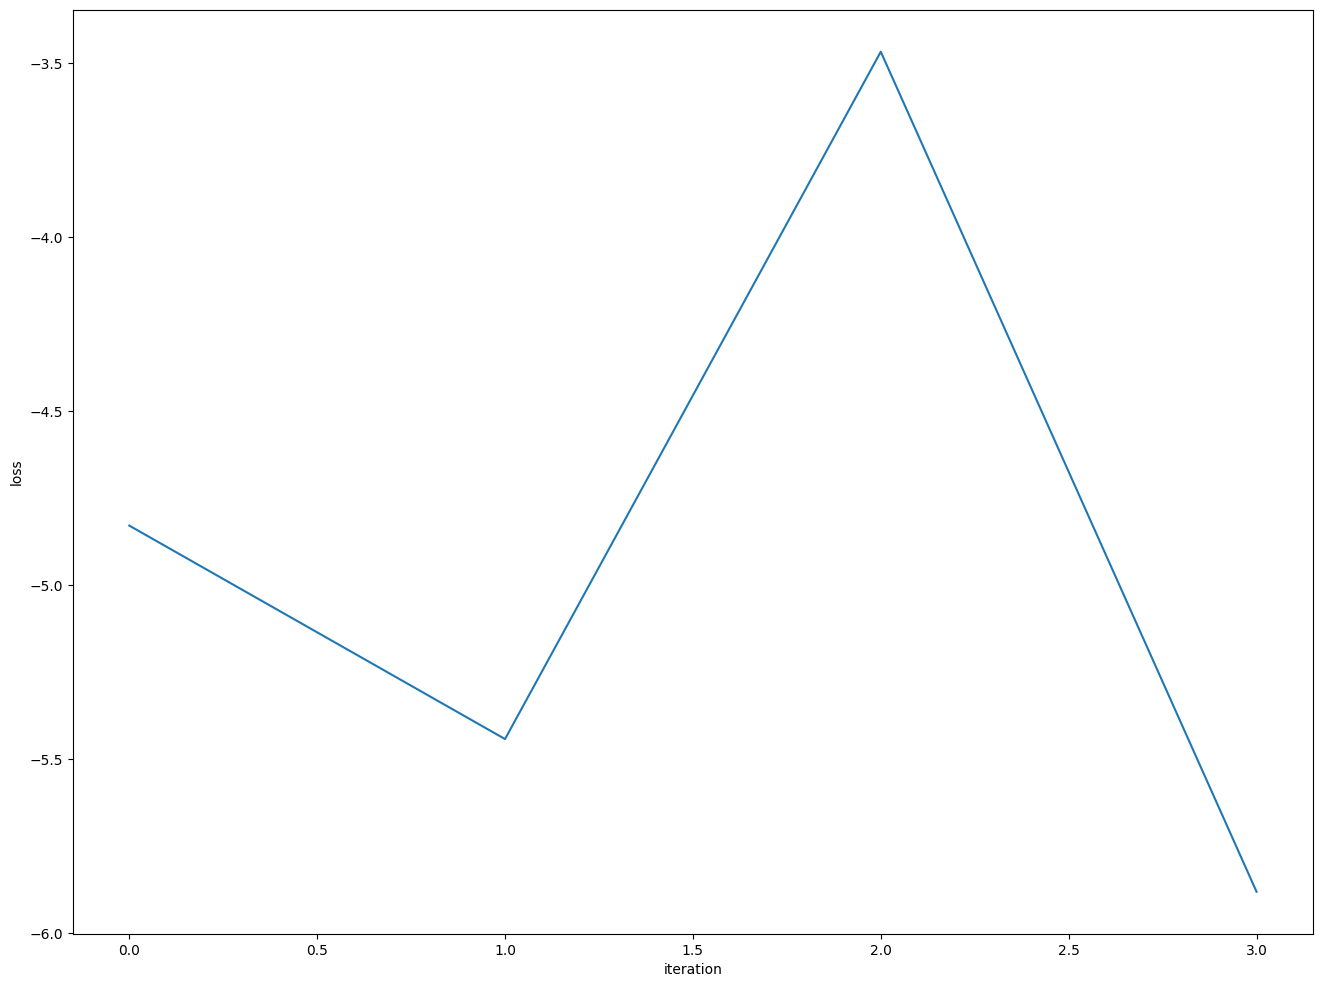

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

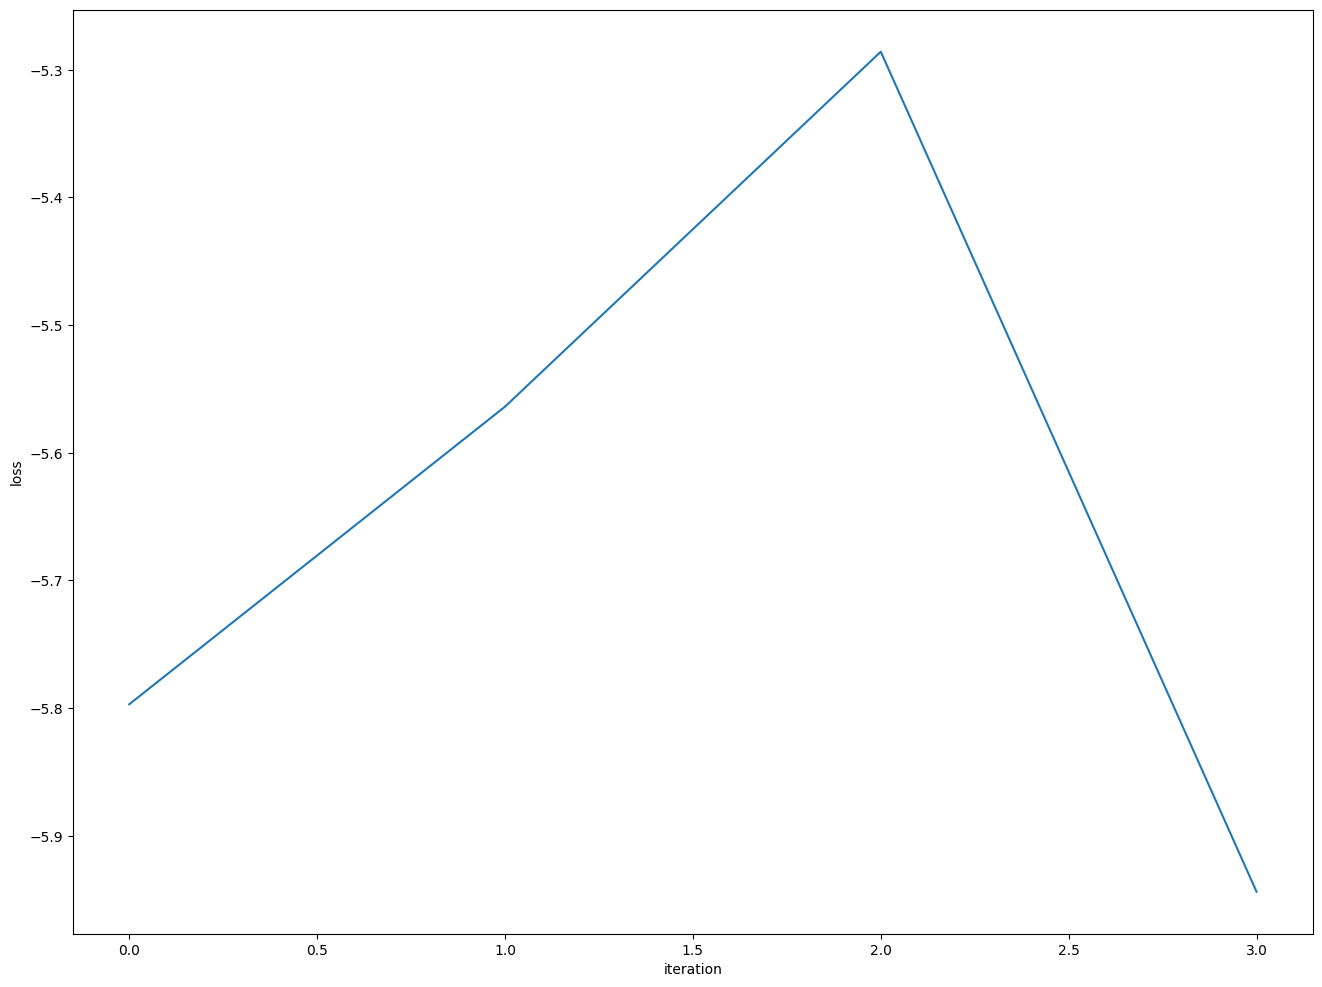

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")